In [1]:
import numpy as np
import torch 
import torch.nn as nn 
import torchvision 

from torch.utils.data import DataLoader, TensorDataset 
from sklearn.mixture import GaussianMixture 

import matplotlib.pyplot as plt 

import tqdm 

torch.manual_seed(1) 
np.random.seed(1) 

from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 08: K-means e Mixture models

## Exercícios práticos

### Ler os dados 

In [2]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

In [3]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray') 
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

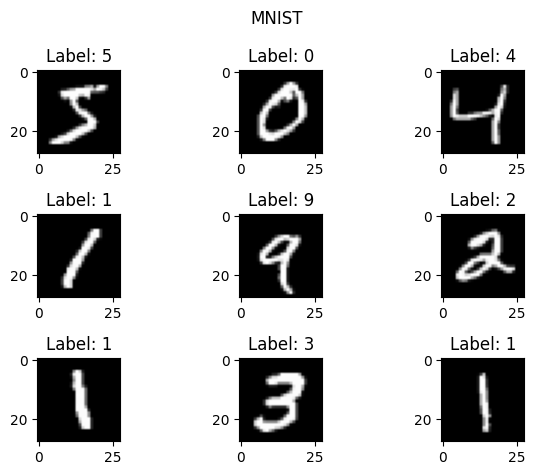

In [4]:
display_nine_images(mnist_trainset)
plt.show()

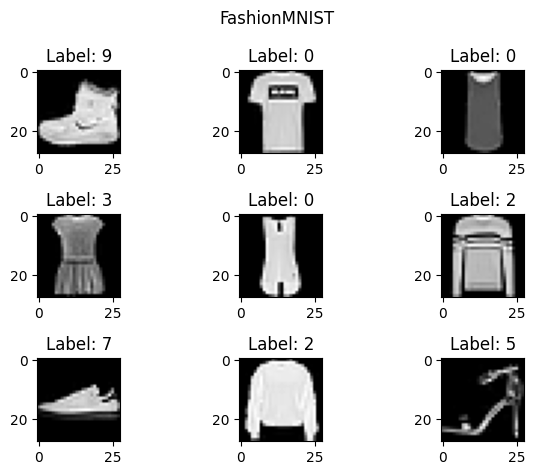

In [5]:
display_nine_images(fashion_mnist_trainset)
plt.show()

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

C:\Users\ilana\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


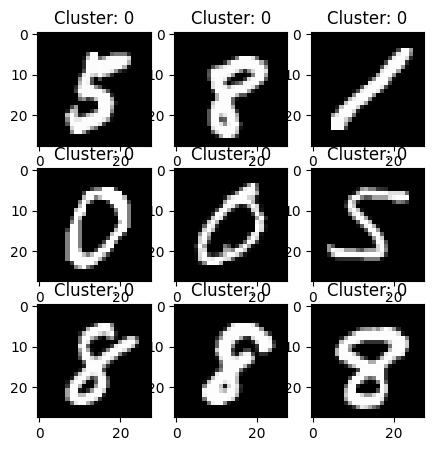

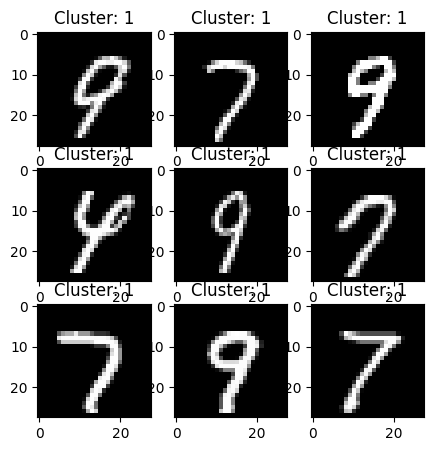

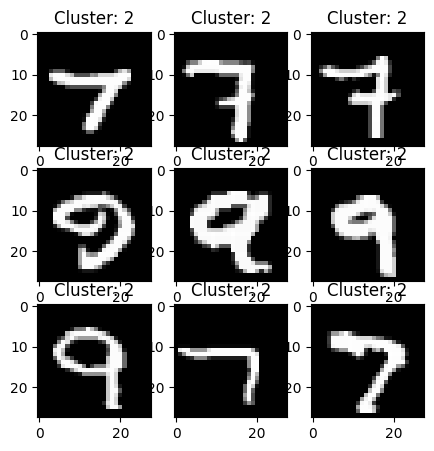

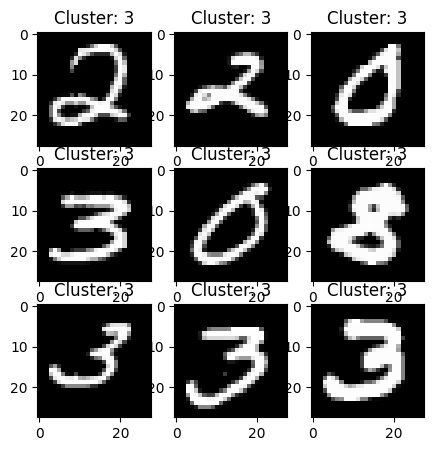

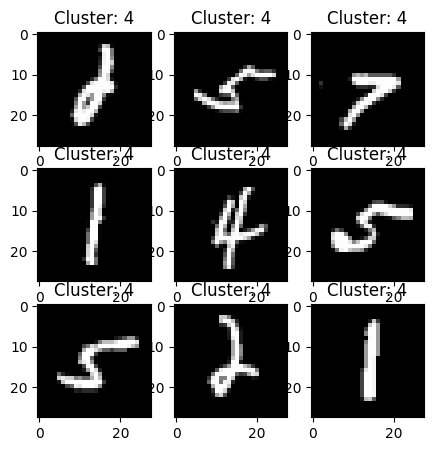

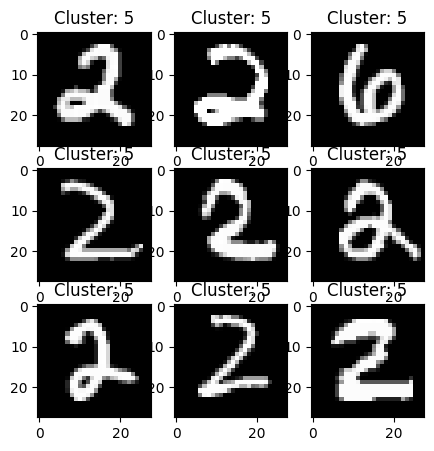

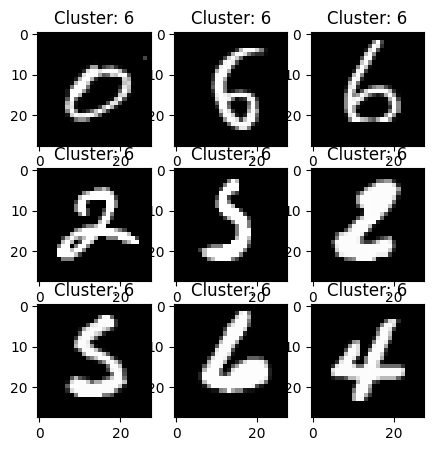

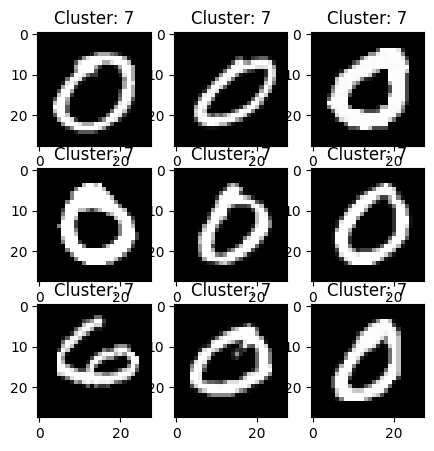

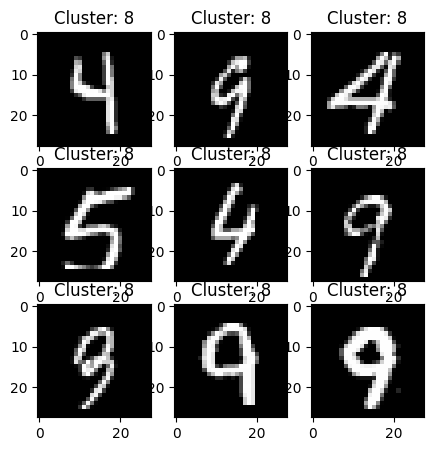

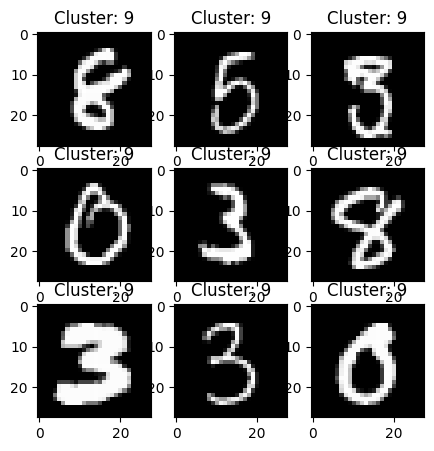

In [6]:
from sklearn.preprocessing import StandardScaler

#Transforma as matrizes 2D em vetores unidimensionais
def prepare_data(dataset):
    data = []
    for image, _ in dataset:
        data.append(image.view(-1).numpy())
    return np.array(data)

# Prepara e escala os dados para terem média 0 e desv. pad. 1
mnist_data = prepare_data(mnist_trainset)
scaler = StandardScaler()
mnist_data = scaler.fit_transform(mnist_data)

# Executa KMeans inicializando os centróides via k-means++
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=1)
kmeans.fit(mnist_data)

def plot_clusters(dataset, kmeans):
    # Determina as labels dos clusters para todos os elementos do conjunto
    labels = kmeans.labels_
    
    for cluster in range(10):
        plt.figure(figsize=(5,5))
        
        # Pega os índices dos elementos do cluster
        indices = np.where(labels == cluster)[0]
        
        # Seleciona 9 índices aleatórios
        indices = np.random.choice(indices, 9, replace=False)
        
        # Plota as imagens
        for i, index in enumerate(indices):
            plt.subplot(3, 3, i + 1)
            image, _ = dataset[index]
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title(f'Cluster: {cluster}')
        plt.show()

plot_clusters(mnist_trainset, kmeans)

C:\Users\ilana\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


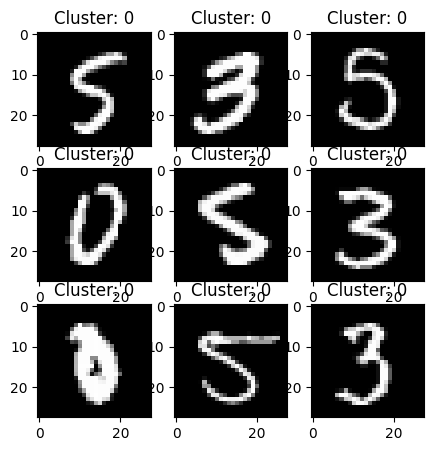

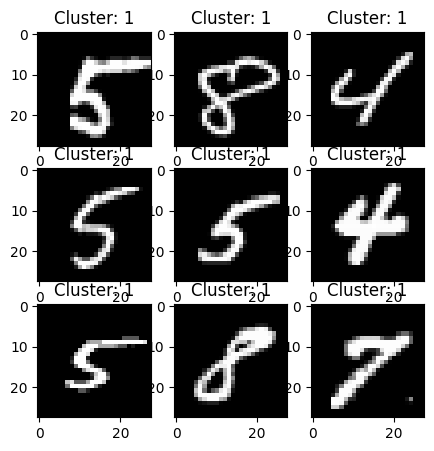

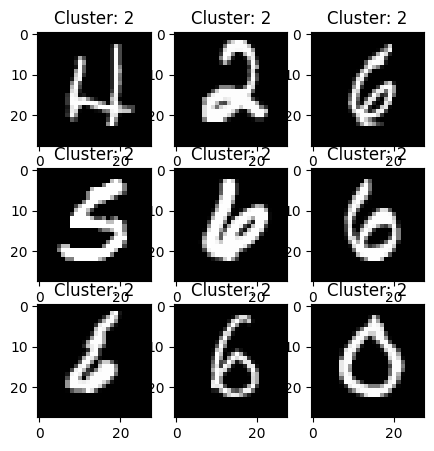

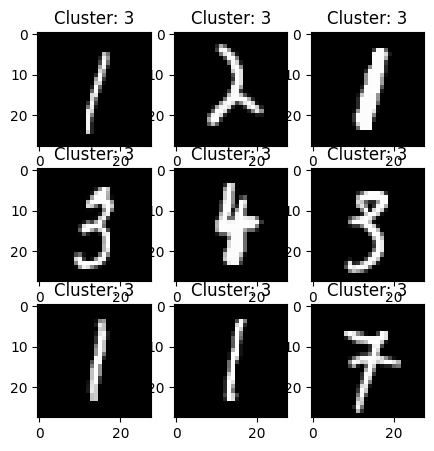

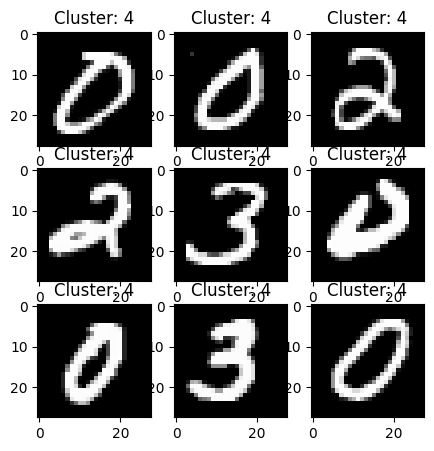

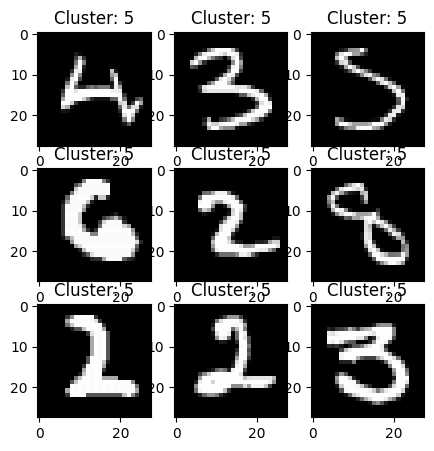

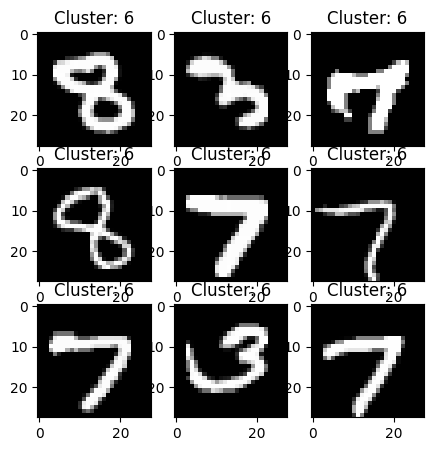

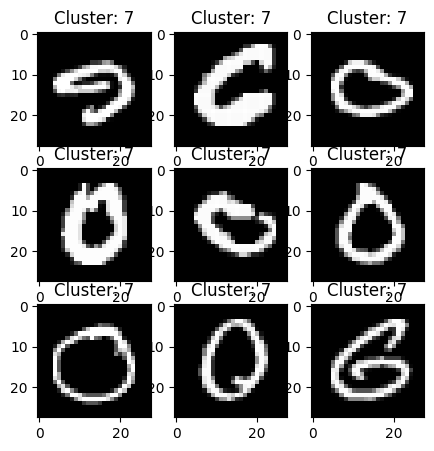

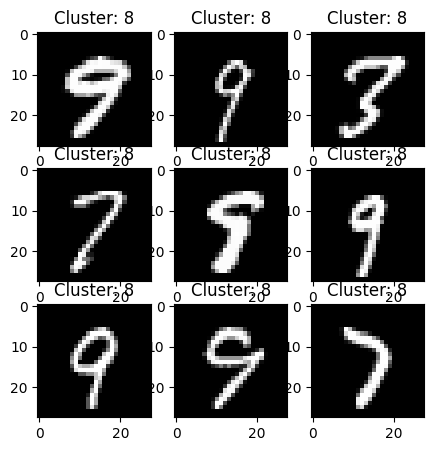

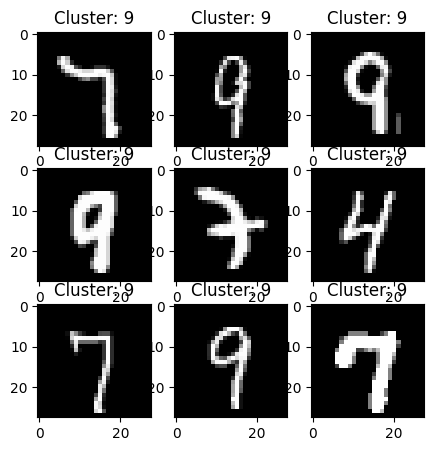

In [7]:
# Executa KMeans inicializando os centróides de maneira aleatória
kmeans_random = KMeans(n_clusters=10, init='random', random_state=1)
kmeans_random.fit(mnist_data)

# Mostra os clusters
plot_clusters(mnist_trainset, kmeans_random)

Em teoria, as imagens plotadas para cada cluster são as que o K-means determinou como as mais semelhantes, com base na distância euclidiana no espaço de recursos, porém dado que o K-means é um método não supervisionado, ele não possui conhecimento dos rótulos, e portanto ele agrupa imagens com valores distintos mas com formatos similares, baseado na semelhança à imagem original em termos da distância euclidiana, ou seja, comparando duas imagens como vetores unidimensionais, calculamos a distância euclidiana entre cada entrada (pixel) dos dois vetores, e as imagens com menor distância entre si serão agrupadas num mesmo cluster. Consequentemente, imagens similares são colocadas juntas tratando-se do valor de cada píxel, e não do valor representado na imagem.

C:\Users\ilana\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ilana\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


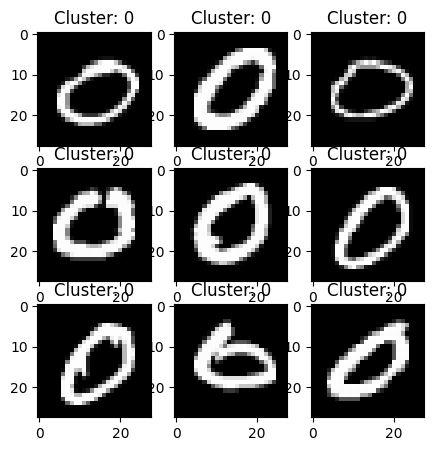

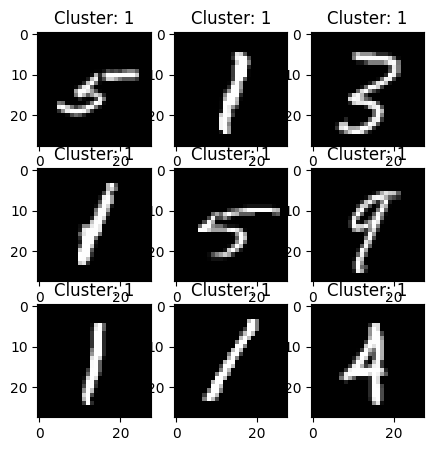

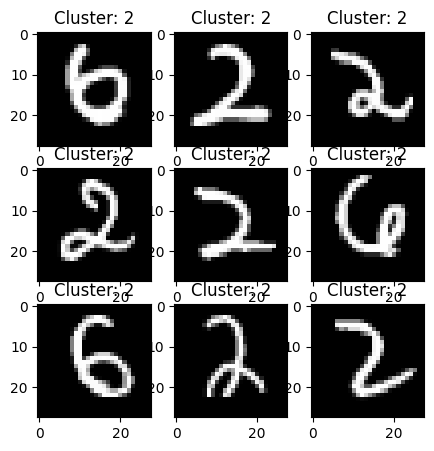

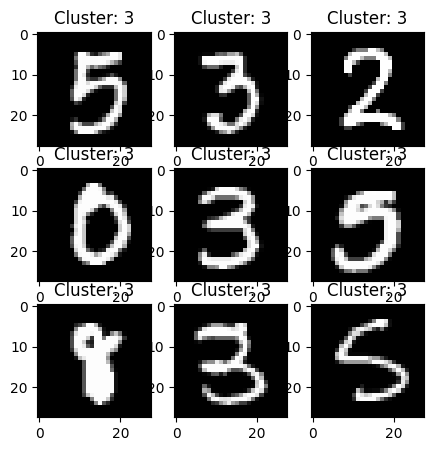

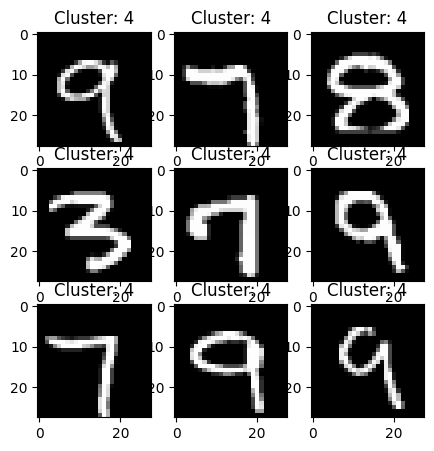

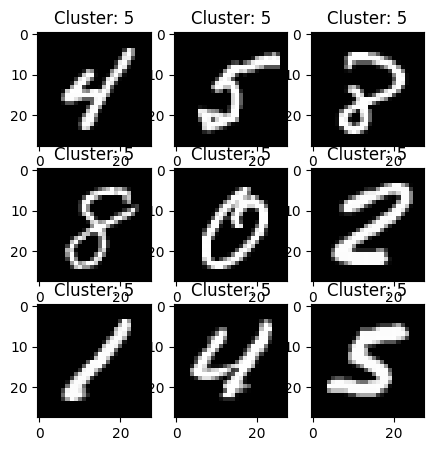

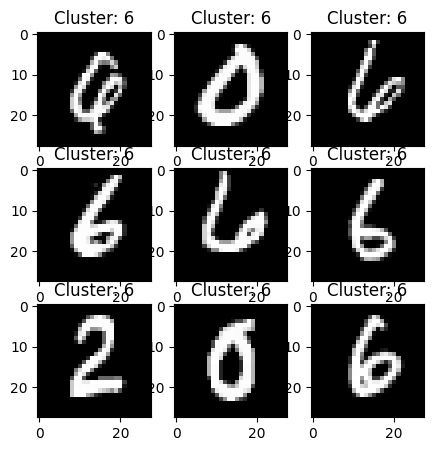

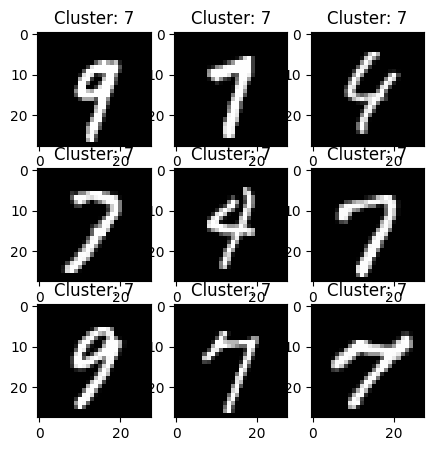

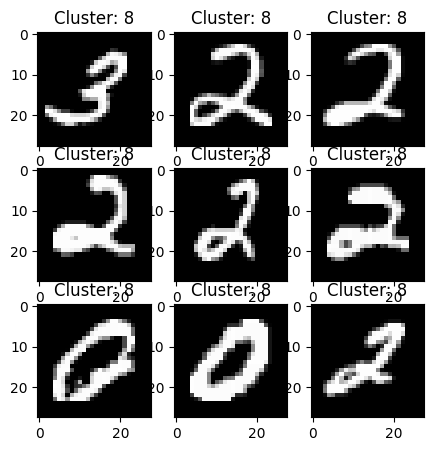

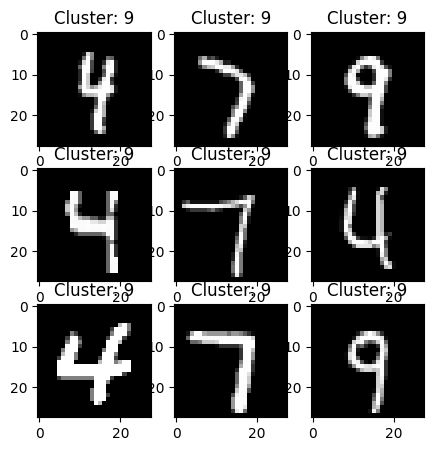

In [8]:
def prepare_data(dataset):
    data = []
    labels = []
    for image, label in dataset:
        data.append(image.view(-1).numpy())
        labels.append(label)
    return np.array(data), np.array(labels)

# Prepara e escala os dados para terem média 0 e desv. pad. 1
mnist_data, mnist_labels = prepare_data(mnist_trainset)
scaler = StandardScaler()
mnist_data = scaler.fit_transform(mnist_data)

# Calculate the centroids
centroids = []
for digit in range(10):
    # Get the indices of the images with the current digit
    indices = np.where(mnist_labels == digit)[0]
    # Calculate the centroid of these images
    centroid = np.mean(mnist_data[indices], axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

# Executa KMeans inicializando os centróides via k-means++
kmeans = KMeans(n_clusters=10, init=centroids, random_state=1)
kmeans.fit(mnist_data)

def plot_clusters(dataset, kmeans):
    # Determina as labels dos clusters para todos os elementos do conjunto
    labels = kmeans.labels_
    
    for cluster in range(10):
        plt.figure(figsize=(5,5))
        
        # Pega os índices dos elementos do cluster
        indices = np.where(labels == cluster)[0]
        
        # Seleciona 9 índices aleatórios
        indices = np.random.choice(indices, 9, replace=False)
        
        # Plota as imagens
        for i, index in enumerate(indices):
            plt.subplot(3, 3, i + 1)
            image, _ = dataset[index]
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title(f'Cluster: {cluster}')
        plt.show()

plot_clusters(mnist_trainset, kmeans)

Inicializando os centroides através do k-means++, é possível notar novamente que as imagens são agrupadas com base no formato e posição, mas é possível perceber que dessa maneira, os clusters apresentam mais dos seus valores respectivos, especialmente nos clusters 0, 2 e 6.

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente, treine um MLP para classificar o MNIST. Com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino). Agora, avalie a capacidade dessa GMM diferenciar amostras de test do MNIST e do FashionMNIST (espera-se que amostras OOD --- do Fashin MNIST--- estejam nas caudas). Teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [9]:
import torch.optim as optim

mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )
        
    def forward(self, x):
        return self.layers(x)

    def penultimate(self, x):
        for layer in self.layers[:-2]:
            x = layer(x)
        return x
    
mlp = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(mnist_trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print('Época %d Perda: %.3f' % (epoch + 1, running_loss / len(mnist_trainloader)))

Época 1 Perda: 1.156
Época 2 Perda: 0.383
Época 3 Perda: 0.312
Época 4 Perda: 0.271
Época 5 Perda: 0.238
Época 6 Perda: 0.210
Época 7 Perda: 0.187
Época 8 Perda: 0.169
Época 9 Perda: 0.153
Época 10 Perda: 0.140


In [10]:
fashion_mnist_testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

penultimate_train_activations = mlp.penultimate(mnist_trainset.data.view(-1, 28*28).float()).detach().numpy()

gmm = GaussianMixture(n_components=10, random_state=0).fit(penultimate_train_activations)

mnist_test_activations = mlp.penultimate(mnist_testset.data.view(-1, 28*28).float()).detach().numpy()
fashion_mnist_test_activations = mlp.penultimate(fashion_mnist_testset.data.view(-1, 28*28).float()).detach().numpy()

mnist_test_scores = gmm.score_samples(mnist_test_activations)
fashion_mnist_test_scores = gmm.score_samples(fashion_mnist_test_activations)

print("Log-verossimilhança médio do MNIST: ", np.mean(mnist_test_scores))
print("Log-verossimilhança médio do FashionMNIST: ", np.mean(fashion_mnist_test_scores))

Log-verossimilhança médio do MNIST:  -287.020106585543
Log-verossimilhança médio do FashionMNIST:  -362.2277632310127


In [11]:
fashion_mnist_testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

penultimate_train_activations = mlp.penultimate(mnist_trainset.data.view(-1, 28*28).float()).detach().numpy()

gmm = GaussianMixture(n_components=5, random_state=0).fit(penultimate_train_activations)

mnist_test_activations = mlp.penultimate(mnist_testset.data.view(-1, 28*28).float()).detach().numpy()
fashion_mnist_test_activations = mlp.penultimate(fashion_mnist_testset.data.view(-1, 28*28).float()).detach().numpy()

mnist_test_scores = gmm.score_samples(mnist_test_activations)
fashion_mnist_test_scores = gmm.score_samples(fashion_mnist_test_activations)

print("Log-verossimilhança médio do MNIST: ", np.mean(mnist_test_scores))
print("Log-verossimilhança médio do FashionMNIST: ", np.mean(fashion_mnist_test_scores))

Log-verossimilhança médio do MNIST:  -294.2622096269357
Log-verossimilhança médio do FashionMNIST:  -353.0413129040175


In [12]:
fashion_mnist_testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

penultimate_train_activations = mlp.penultimate(mnist_trainset.data.view(-1, 28*28).float()).detach().numpy()

gmm = GaussianMixture(n_components=20, random_state=0).fit(penultimate_train_activations)

mnist_test_activations = mlp.penultimate(mnist_testset.data.view(-1, 28*28).float()).detach().numpy()
fashion_mnist_test_activations = mlp.penultimate(fashion_mnist_testset.data.view(-1, 28*28).float()).detach().numpy()

mnist_test_scores = gmm.score_samples(mnist_test_activations)
fashion_mnist_test_scores = gmm.score_samples(fashion_mnist_test_activations)

print("Log-verossimilhança médio do MNIST: ", np.mean(mnist_test_scores))
print("Log-verossimilhança médio do FashionMNIST: ", np.mean(fashion_mnist_test_scores))

Log-verossimilhança médio do MNIST:  -281.28730870795454
Log-verossimilhança médio do FashionMNIST:  -346.33267104951705


In [13]:
num_components = list(range(1, 16))  # testando de 1 a 15 componentes (20 levou muito tempo)
differences = []

for num in num_components:
    gmm = GaussianMixture(n_components=num, random_state=0).fit(penultimate_train_activations)

    mnist_test_scores = gmm.score_samples(mnist_test_activations)
    fashion_mnist_test_scores = gmm.score_samples(fashion_mnist_test_activations)

    difference = np.mean(mnist_test_scores) - np.mean(fashion_mnist_test_scores)
    differences.append(difference)
    
    print(f"Para {num} componentes: " "\n"
            f"Log-verossimilhança médio do MNIST: {np.mean(mnist_test_scores)}, " "\n"
            f"Log-verossimilhança médio do FashionMNIST: {np.mean(fashion_mnist_test_scores)}, " "\n"
            f"Diferença: {difference}" "\n")
        
best_num_components = num_components[np.argmax(differences)]
print("Melhor número de componentes: ", best_num_components)

Para 1 componentes: 
Log-verossimilhança médio do MNIST: -312.9339098760883, 
Log-verossimilhança médio do FashionMNIST: -357.70943381914157, 
Diferença: 44.77552394305326

Para 2 componentes: 
Log-verossimilhança médio do MNIST: -307.3196100842355, 
Log-verossimilhança médio do FashionMNIST: -357.1935779997221, 
Diferença: 49.87396791548662

Para 3 componentes: 
Log-verossimilhança médio do MNIST: -299.9850877685604, 
Log-verossimilhança médio do FashionMNIST: -353.22540385996876, 
Diferença: 53.240316091408374

Para 4 componentes: 
Log-verossimilhança médio do MNIST: -296.1481708001133, 
Log-verossimilhança médio do FashionMNIST: -356.1497502013249, 
Diferença: 60.001579401211586

Para 5 componentes: 
Log-verossimilhança médio do MNIST: -294.2622096269357, 
Log-verossimilhança médio do FashionMNIST: -353.0413129040175, 
Diferença: 58.77910327708179

Para 6 componentes: 
Log-verossimilhança médio do MNIST: -292.45355925646965, 
Log-verossimilhança médio do FashionMNIST: -360.220577978

Como queremos que o modelo GMM seja capaz de distinguir entre as amostras "in-distribution" (os dados de teste do MNIST) e as amostras "out-of-distribution" (os dados de teste da FashionMNIST), o maior valor dessa diferença indica que o modelo atribui uma probabilidade muito mais alta às amostras MNIST do que às amostras FashionMNIST, como desejado, visto que as amostras MNIST são as que estão presentes na distribuição, encontrando então o número de componentes da mistura que permite ao modelo fazer a melhor distinção entre amostras "in-distribution" e "out-of-distribution".

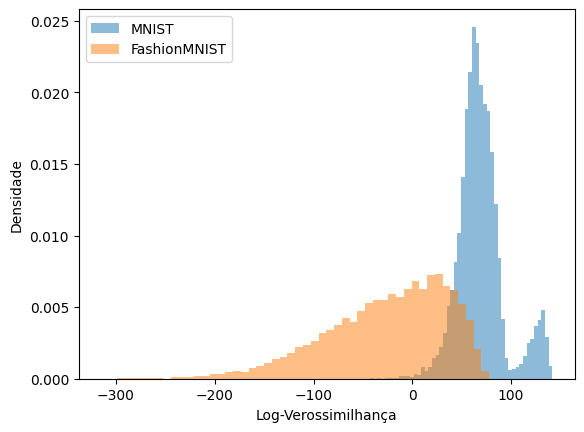

In [17]:
def prepare_data(dataset):
    data = []
    for image, _ in dataset:
        # Add a check for dimension consistency
        if image.shape != (1, 28, 28):
            raise ValueError(f'Expected image shape (1, 28, 28), but got {image.shape}')
        data.append(image.view(-1).numpy())
    return np.array(data)

fashion_mnist_data = prepare_data(fashion_mnist_trainset)
fashion_mnist_data = scaler.transform(fashion_mnist_data)  

def compute_penultimate_activations(data_loader, model):
    activations = []
    model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.view(-1, 28*28)
            activations_batch = model.penultimate(images).numpy()
            activations.extend(activations_batch)
    return np.array(activations)

mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)
mnist_activations = compute_penultimate_activations(mnist_testloader, mlp)

fashion_mnist_testloader = DataLoader(fashion_mnist_testset, batch_size=64, shuffle=False)
fashion_mnist_activations = compute_penultimate_activations(fashion_mnist_testloader, mlp)

gmm = GaussianMixture(n_components=10, random_state=1)
gmm.fit(mnist_activations)

mnist_log_likelihoods = gmm.score_samples(mnist_activations)

fashion_mnist_log_likelihoods = gmm.score_samples(fashion_mnist_activations)

plt.hist(mnist_log_likelihoods, bins=50, density=True, alpha=0.5, label="MNIST")
plt.hist(fashion_mnist_log_likelihoods, bins=50, density=True, alpha=0.5, label="FashionMNIST")
plt.xlabel("Log-Verossimilhança")
plt.ylabel("Densidade")
plt.legend()
plt.show()

## Exercício de "papel e caneta"

**1.** Como vimos anteriormente, a função custo para $k$-means é:
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \| x - \mu_i \|_2^2,
\end{equation}
a qual otimizamos atualizando os clusters e seus respectivos centróides de maneira alternada. Suponha, no entanto, que nosso banco de dados contém entradas faltantes, i.e., existe algum vetor $x=[x_1, \ldots, x_D]$ para o qual apenas as entradas $x_o \forall o(x) \in O(x) \subseteq \{1,\ldots,D\}$ foram observadas. Deixe, similarmente, que $M(x)$ denote o conjunto de índices faltantes em $x$. Existem várias maneiras de contornar esse problema. A mais animalesca (e que descarta menos informação) é jogar fora amostras com entradas faltantes. Pode-se também pré-processar o banco de dados para preencher os valores faltantes. Uma terceira opção é codificar nossa incerteza sobre $x_{M(x)}$ como uma distribuição e propagar essa incerteza pela nossa função custo. Caso não saibamos muito sobre esses valores faltantes, por exemplo, podemos atribuir uma Gaussiana com média zero e variância $c>0$ para cada $x_m \forall m \in M(x)$. Nesse caso, nossa função custo se transforma em: 
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\big[\| x - \mu_i \|_2^2\big],
\end{equation}

Derive algoritmo para otimizar a função acima --- de maneira similar à que derivamos o $k$-means. Comente como seu algoritmo difere do $K$-means original.



Podemos derivar esse algoritmo da seguinte forma:

1. Selecionar aleatoriamente $K$ pontos como centróides iniciais. 
2. Atribuímos cada ponto ao centróide mais próximo, calculando a distância euclidiana ponderada, onde a ponderação leva em consideração a incerteza dos valores faltantes. Como estamos usando uma Gaussiana de média 0 e variância $c$ para cada valor faltante, a distância entre $x$ e o centróide $\mu_i$ é dada por:

\begin{gather*}
d(x, \mu_i) = \sum_{o \in O(x)} (x_o - \mu_{io})^2 + c |M(x)|
\end{gather*}

3. Atualizar os centróides para que se tornem a média dos pontos em seu cluster, levando em consideração apenas as entradas observadas:

\begin{gather*}
\mu_{io} = \frac{1}{|C_i|} \sum_{x \in C_i} x_o, \forall o \in O(x),
\end{gather*}
onde $|C_i|$ é o número de pontos no cluster $i$.

4. Repetir os passos 2 e 3 até que os centróides não se alterem ou até que um máximo de iterações seja atingido.

Esse algoritmo difere do $k$-means original na etapa de atribuição de cluster, onde calculamos uma distância ponderada que leva em consideração a incerteza dos valores faltante, e na etapa de atualização dos centróides, em que apenas calculamos a média das entradas observadas, ao invés da média de todas as entradas.

**2.** Na aula, motivamos o uso de _Gaussian Mixture Models_ (GMMs) e discutimos como estimar seus parâmetros via máxima verossimilhança. Mais especificamente, começamos a derivar um algoritmo de _coordinate ascent_ para maximizar a verossimilhança. Siga os passos da Seção 9.2 do _Pattern Recognition and Machine Learning_ (C. Bishop) e mostre a derivação passo-a-passo (boa parte está omitida no livro) do algoritmo.

Definindo primeiro o modelo GMM, supomos que temos um conjunto de observações $\{x_1, \ldots , x_N\}$, e queremos modelar a sua distribuição como uma mistura de $K$ componentes Gaussianos. Cada componente $k$ tem uma média $\mu_k$, uma matriz de covariância $\Sigma_k$ e um peso $\pi_k$. A função de densidade de probabilidade para a GMM é:

\begin{gather*}
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k,\Sigma_k),
\end{gather*}

onde $0 \leq \pi_k \leq 1$, $\sum_{k=1}^K \pi_k = 1$ e $\mathcal{N}(x|\mu,\Sigma) = \dfrac{1}{(2\pi)^{n/2}det(\Sigma)^{1/2}}\exp[-\dfrac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)]$.

Sendo $Z \sim \text{Cat}(\pi_1, \ldots, \pi_k), Z \in \{1, 2, \ldots, K\}$, podemos aplicar clustering em $x_1, \ldots, x_k$ estimando os valores para o conjunto de parâmetros do modelo $\Theta = \{\mu_1, \ldots, \mu_k, \Sigma_1, \ldots, \Sigma_k, \pi_1, \ldots, \pi_k\}$, atribuindo $x_i$ à Gaussiana (cluster) mais provável de gerar esse valor:

\begin{gather*}
\text{arg max}_{k\in \{1,…,K\}}P(Z_i=k∣x_i;\hat{\Theta})
\end{gather*}

Agora, usando a regra de Bayes:
\begin{gather*}
P(Z_i=k∣x_i;\hat{\Theta})=\dfrac{p(x_i∣Z_i=k;\hat{\Theta})P(Z_i=k;\hat{\Theta})}{\sum_{h=1}^K p(x_i∣Z_i=h;\hat{\Theta})P(Z_i=h;\hat{\Theta})}=\dfrac{\mathcal{N}(x_i∣\hat{\mu_k},\hat{\Sigma_k})\hat{\pi_k}}{\sum_{h=1}^K \mathcal{N}(x_i∣\hat{\mu_h},\hat{\Sigma_h})\hat{\pi_h}}
\end{gather*}

Com isso, temos 

\begin{gather*}
\hat{\Theta} := \text{arg max}_{\Theta}\prod_{i=1}^n p(x_i; \Theta)
\end{gather*}

Assim, chegamos ao algoritmo que usaremos para estimar a máxima verossimilhança: o algoritmo EM.

No passo E, calculamos a propriedade de geração que cada componente Gaussiano tem para cada ponto de dados, usando a função $Q$:

\begin{gather*}
Q_t(\Theta):=\sum_{i=1}^n \sum_{k=1}^K \gamma_{t,i,k} log[\pi_k \mathcal{N}(x_i;\mu_k,\Sigma_k)],
\end{gather*}

onde

\begin{gather*}
\gamma_{t,i,k}:=\dfrac{\pi_{t,k} \mathcal{N}(x_i;\mu_{t,k},\Sigma_{t,k})}{\sum_{h=1}^K \pi_{t,h} \mathcal{N}(x_i;\mu_{t,h},\Sigma_{t,h})}
\end{gather*}

e $\pi_{t,k}, \mu_{t,k}$ e $\Sigma_{t,k}$ são as $t$-ésimas estimativas de $\pi_k,\mu_k,\Sigma_k$.

No passo M, calculamos $\Theta$ que maximiza $Q_t(\Theta)$, ou seja, calculamos $\Theta_{t+1}:=\text{arg max}_{\Theta} Q_t(\Theta)$. Isso pode ser resolvido por:

\begin{gather*}
\forall k, \pi_{t+1,k} := \dfrac{1}{n}\sum_{i=1}^n \gamma_{t,i,k}
\\
\forall k, \mu_{t+1,k} := \dfrac{1}{\sum{i=1}^n \gamma_{t,i,k}}\sum_{i=1}^n \gamma_{t,i,k}x_i
\\
\forall k, \Sigma_{t+1,k} := \dfrac{1}{\sum{i=1}^n \gamma_{t,i,k}}\sum_{i=1}^n \gamma_{t,i,k}(x_i−\mu_{t,k})(x_i−\mu_{t,k})^T
\end{gather*}

Derivando o passo E:

\begin{gather*}
Q_t(\Theta):=E_{Z∣X;\Theta_t}[log p(X,Z;\Theta)] = 
\\
= \sum_{i=1}^n E_{z_i∣x_i;\Theta_t}[log p(x_i,z_i;\Theta)] = 
\\
= \sum_{i=1}^n \sum_{k=1}^K P(z_i=k∣x_i;\Theta_t)log p(x_i,z_i;\Theta)=
\\
= \sum_{i=1}^n \sum_{k=1}^K \dfrac{P(x_i|z_i=k; \Theta_t)P(z_i=k; \Theta_t)}{\sum_{h=1}^K P(x_i|z_i=h; \Theta_t)P(z_i=h; \Theta_t)}log p(x_i,z_i;\Theta) = 
\\
= \sum_{i=1}^n \sum_{k=1}^K \dfrac{\pi_{t,k} \mathcal{N}(x_i;\mu_{t,k},\Sigma_{t,k})}{\sum_{h=1}^K \pi_{t,h} \mathcal{N}(x_i;\mu_{t,h},\Sigma_{t,h})}log \pi_{k} \mathcal{N}(x_i;\mu_{k},\Sigma_{k}) = 
\\
= \sum_{i=1}^n \sum_{k=1}^K \gamma_{t,i,k} log \pi_{k} \mathcal{N}(x_i;\mu_{k},\Sigma_{k})
\end{gather*}

Derivando o passo M:

Queremos resolver $\Theta_{t+1}:=\text{arg max}_{\Theta} Q_t(\Theta)$ sujeito a $\sum_{k=1}^K \pi_k = 1$. Isso pode ser feito através dos multiplicadores de Lagrange:

\begin{gather*}
L(\Theta,\lambda) :=\sum_{i=1}^n \sum_{k=1}^K \gamma_{t,i,k} log \pi_{k} \mathcal{N}(x_i;\mu_{k},\Sigma_{k}) +\lambda(\sum_{k=1}^K \pi_k−1)
\end{gather*}

Para algum $k$, $\dfrac{\partial L(\Theta,\lambda)}{\partial \pi_k } = \dfrac{1}{\pi_k} \sum_{i=1}^n \gamma_{t,i,k} + \lambda$. Igualando a 0 e resolvendo para $\pi_k$, temos $\pi_k = -\dfrac{1}{\lambda} \sum_{i=1}^n \gamma_{t,i,k}$. Usando isso na restrição $\sum_{k=1}^K \pi_k = 1$, resolvemos para $\lambda$:

\begin{gather*}
\sum_{k=1}^K -\dfrac{1}{\lambda} \sum_{i=1}^n \gamma_{t,i,k} = 1 \Rightarrow
\\
\lambda = - \sum_{i=1}^n \sum_{k=1}^K \gamma_{t,i,k} \Rightarrow
\\
\lambda = -n,
\end{gather*}
já que $\sum_{k=1}^K \gamma_{t,i,k} = 1$. Botando $\lambda$ de volta na equação que define a derivada do Lagrangiano como 0, podemos achar $\pi_k$:

\begin{gather*}
0 = \dfrac{1}{\pi_k} \sum_{i=1}^n \gamma_{t,i,k} + \lambda \Rightarrow \dfrac{1}{\pi_k} \sum_{i=1}^n \gamma_{t,i,k} -n \Rightarrow \pi_k = \dfrac{1}{n} \sum_{i=1}^n \gamma_{t,i,k}
\end{gather*}

Calculando o Lagrangiano com respeito a $\mu$:

\begin{gather*}
\dfrac{\partial L(\Theta,\lambda)}{\partial \mu_k } := \sum_{i=1}^n \gamma_{t,i,k} \dfrac{\partial}{\partial \mu_k} log \pi_k \mathcal{N}(x_i;\mu_{k},\Sigma_{k}) = 
\\
= \sum_{i=1}^n \dfrac{\gamma_{t,i,k}}{\pi_k \mathcal{N}(x_i;\mu_{k},\Sigma_{k})} \dfrac{\partial}{\partial \mu_k} log \pi_k \mathcal{N}(x_i;\mu_{k},\Sigma_{k}) = 
\\
= \sum_{i=1}^n \gamma_{t,i,k}[-2\Sigma_k^{-1}(x_i-\mu_k)]
\end{gather*}

Para que possamos resolver:

\begin{gather*}
0 = \sum_{i=1}^n \gamma_{t,i,k}[-2\Sigma_k^{-1}(x_i-\mu_k)] = 
\\
= \Sigma_k^{-1}\sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_k) \Rightarrow 
\\
\Rightarrow \Sigma_k0 = \Sigma_k \Sigma_k^{-1}\sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_k) \Rightarrow 
\\
\Rightarrow 0 = \sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_k) \Rightarrow \mu_k = \dfrac{1}{\sum_{i=1}^n \gamma_{t,i,k}}\sum_{i=1}^n \gamma_{t,i,k}x_i
\end{gather*}

Agora, para $\Sigma_k$:

\begin{gather*}
\dfrac{\partial L(\Theta,\lambda)}{\partial \Sigma_k } := \sum_{i=1}^n \gamma_{t,i,k} \dfrac{\partial}{\partial \Sigma_k} log \pi_k \mathcal{N}(x_i;\mu_{k},\Sigma_{k}) =
\\
= \sum_{i=1}^n \dfrac{\gamma_{t,i,k}}{\pi_k \mathcal{N}(x_i;\mu_{k},\Sigma_{k})} \dfrac{\partial}{\partial \Sigma_k} log \pi_k \mathcal{N}(x_i;\mu_{k},\Sigma_{k}) = 
\\
= \sum_{i=1}^n \gamma_{t,i,k} [-\dfrac{1}{2}\dfrac{\partial}{\partial \Sigma_k} log \text{det}(\Sigma_k) -\dfrac{1}{2}\dfrac{\partial}{\partial \Sigma_k}(x_i-\mu_k)^T\Sigma_k^{-1}(x_i-\mu_k)] =
\\
= \sum_{i=1}^n \gamma_{t,i,k} -\dfrac{1}{2}\Sigma_k^{-1} - \gamma_{t,i,k}\dfrac{1}{2}\dfrac{\partial}{\partial \Sigma_k}(x_i-\mu_k)^T\Sigma_k^{-1}(x_i-\mu_k) = 
\\
= -\dfrac{1}{2} \sum_{i=1}^n \gamma_{t,i,k}\Sigma_k^{-1} -\gamma_{t,i,k}\Sigma_k^{-1}(x_i-\mu_i)(x_i-\mu_i)^T\Sigma_k^{-1} =
\\
= -\dfrac{1}{2} (\sum_{i=1}^n \gamma_{t,i,k})\Sigma_k^{-1} -\Sigma_k^{-1}(\sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_i)(x_i-\mu_i)^T)\Sigma_k^{-1}
\end{gather*} 

Igualando a 0:

\begin{gather*}
0 = \dfrac{1}{2} (\sum_{i=1}^n \gamma_{t,i,k})\Sigma_k^{-1} -\Sigma_k^{-1}(\sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_i)(x_i-\mu_i)^T)\Sigma_k^{-1} \Rightarrow 
\\
\Rightarrow 0 = \Sigma_k^{-1}[(\sum_{i=1}^n \gamma_{t,i,k})I - (\sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_i)(x_i-\mu_i)^T)\Sigma_k^{-1}] \Rightarrow
\\
\Rightarrow 0 = (\sum_{i=1}^n \gamma_{t,i,k})I- (\sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_i)(x_i-\mu_i)^T)\Sigma_k^{-1} \Rightarrow
\\
\Rightarrow (\sum_{i=1}^n \gamma_{t,i,k})I =  (\sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_i)(x_i-\mu_i)^T)\Sigma_k^{-1} \Rightarrow
\\
\Rightarrow (\sum_{i=1}^n \gamma_{t,i,k})\Sigma_k =  \sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_i)(x_i-\mu_i)^T \Rightarrow 
\\
\Rightarrow \Sigma_k = \dfrac{1}{\sum_{i=1}^n \gamma_{t,i,k}}\sum_{i=1}^n \gamma_{t,i,k}(x_i-\mu_i)(x_i-\mu_i)^T
\end{gather*}

Referência: https://mbernste.github.io/posts/gmm_em/